(800, 800)


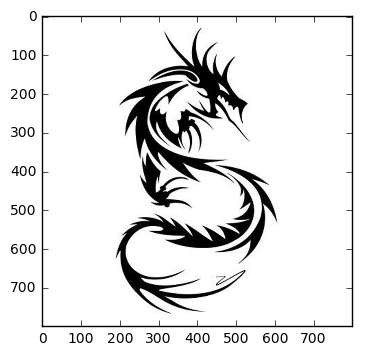

In [155]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

img = Image.open('dragon.jpg')
img = img.convert('RGB')

print(img.size)
plt.imshow(img)


In [171]:
TILE_SIZE = 10

class Tile:
    def get_pixel(self, row, col):
        return self.pixels[row][col]
    
    def __init__(self, pixels):
        self.pixels = pixels
    

In [172]:
WIDTH = img.size[0]
HEIGHT = img.size[1]

def get_tiles_from_img(img):
    img_data = np.array(img.getdata()).reshape(WIDTH, HEIGHT, 3) 
    
    print("Img data shape: ", img_data.shape)   
    
    width_tiles = WIDTH // TILE_SIZE
    height_tiles = HEIGHT // TILE_SIZE
    tiles = []
    for row in range(height_tiles):
        for col in range(width_tiles):
            
            pixels = []
            count = 0
            for offset_row in range(TILE_SIZE):
                for offset_col in range(TILE_SIZE):
                    pixels.append(img_data[row * TILE_SIZE + offset_row][col * TILE_SIZE + offset_col])
                
            tiles.append(Tile(np.array(pixels).reshape(TILE_SIZE, TILE_SIZE, 3)))
    
    return np.array(tiles).reshape(width_tiles, height_tiles)

if WIDTH % TILE_SIZE != 0 or HEIGHT % TILE_SIZE != 0:
    print("Unsupported combination of tile size / img size")
    
tiles = get_tiles_from_img(img)
print("Tiles shape: ", tiles.shape)
#print(tiles)

    

Img data shape:  (800, 800, 3)
Tiles shape:  (80, 80)


(800, 800, 3)


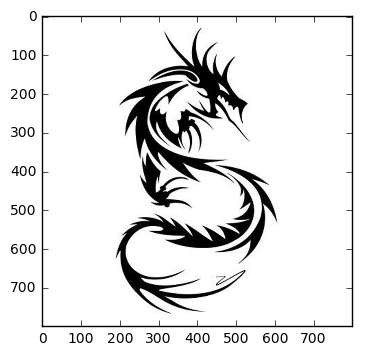

In [175]:
def print_tiles(tiles):    
    pixels = np.empty([WIDTH, HEIGHT, 3])
    for row in range(HEIGHT // TILE_SIZE):
        for col in range(WIDTH // TILE_SIZE):
            for offset_row in range(TILE_SIZE):
                for offset_col in range(TILE_SIZE):
                    tile = tiles[row][col]
                    pixels[row * TILE_SIZE + offset_row][col * TILE_SIZE + offset_col] = tile.get_pixel(offset_row, offset_col)
    print(pixels.shape)
    im = Image.fromarray(np.uint8(pixels))
    plt.imshow(im)

print_tiles(tiles)